<a href="https://colab.research.google.com/github/royd2023/Cats-VS-Dogs/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [14]:
# 3
import os
import shutil

# Create a subdirectory for test images
test_subdir = os.path.join(test_dir, 'images')
if not os.path.exists(test_subdir):
    os.makedirs(test_subdir)
    # Move all images to the subdirectory
    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(test_dir, filename)
            dst = os.path.join(test_subdir, filename)
            if os.path.isfile(src):  # Make sure it's a file
                shutil.move(src, dst)

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=validation_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=test_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode= None,
                                                     shuffle = False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [21]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])
print(sample_training_images[0].shape)


(150, 150, 3)


In [17]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True,
                                   zoom_range = 0.2)


In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [25]:
# 7
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),  # This is the "fully connected layer activated by ReLU"
    Dense(1, activation='sigmoid')  # Output layer for class probabilities
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,641,441 (40.59 MB)

 Trainable params: 10,641,441 (40.59 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4966 - loss: 1.0492

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.4973 - loss: 1.0369 - val_accuracy: 0.5033 - val_loss: 0.6925
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.4766 - loss: 0.6964

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4766 - loss: 0.6964 - val_accuracy: 0.5100 - val_loss: 0.6917
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.5531 - loss: 0.6903 - val_accuracy: 0.5246 - val_loss: 0.6808
Epoch 4/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5625 - loss: 0.6809

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5625 - loss: 0.6809 - val_accuracy: 0.5190 - val_loss: 0.6801
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.5532 - loss: 0.6767 - val_accuracy: 0.6205 - val_loss: 0.6558
Epoch 6/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6484 - loss: 0.6431

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 552ms/step - accuracy: 0.6484 - loss: 0.6431 - val_accuracy: 0.6116 - val_loss: 0.6506
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.6224 - loss: 0.6374 - val_accuracy: 0.5982 - val_loss: 0.6641
Epoch 8/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.5703 - loss: 0.6913

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.5703 - loss: 0.6913 - val_accuracy: 0.6217 - val_loss: 0.6321
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.6522 - loss: 0.6273 - val_accuracy: 0.6183 - val_loss: 0.6250
Epoch 10/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6797 - loss: 0.5699

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6797 - loss: 0.5699 - val_accuracy: 0.6540 - val_loss: 0.6185
Epoch 11/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.6592 - loss: 0.6042 - val_accuracy: 0.6094 - val_loss: 0.6442
Epoch 12/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.5938 - loss: 0.6759

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.5938 - loss: 0.6759 - val_accuracy: 0.5569 - val_loss: 0.6868
Epoch 13/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.6284 - loss: 0.6261 - val_accuracy: 0.6484 - val_loss: 0.6062
Epoch 14/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6250 - loss: 0.6134

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 597ms/step - accuracy: 0.6250 - loss: 0.6134 - val_accuracy: 0.6775 - val_loss: 0.6027
Epoch 15/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.6876 - loss: 0.5945 - val_accuracy: 0.6696 - val_loss: 0.5857


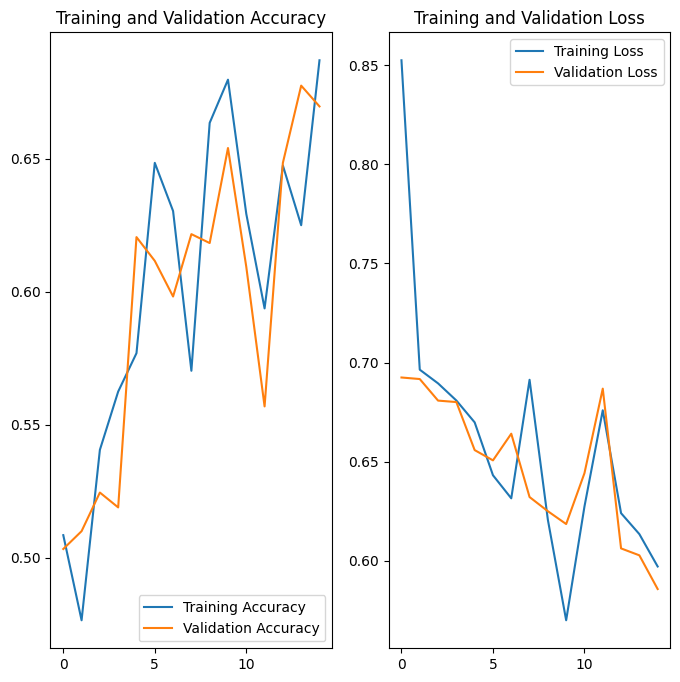

In [27]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


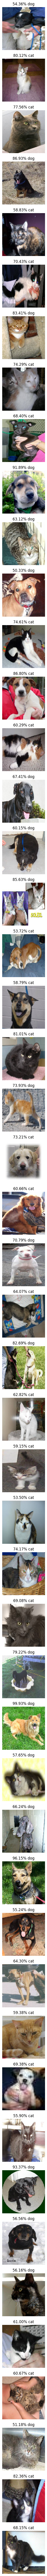

In [32]:
predictions = model.predict(test_data_gen)
probabilities = predictions.flatten()

test_data_gen.reset()
test_images = test_data_gen[0]

plotImages(test_images, probabilities)

In [30]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
